In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

Found 32680 images belonging to 10 classes.
Found 8164 images belonging to 10 classes.


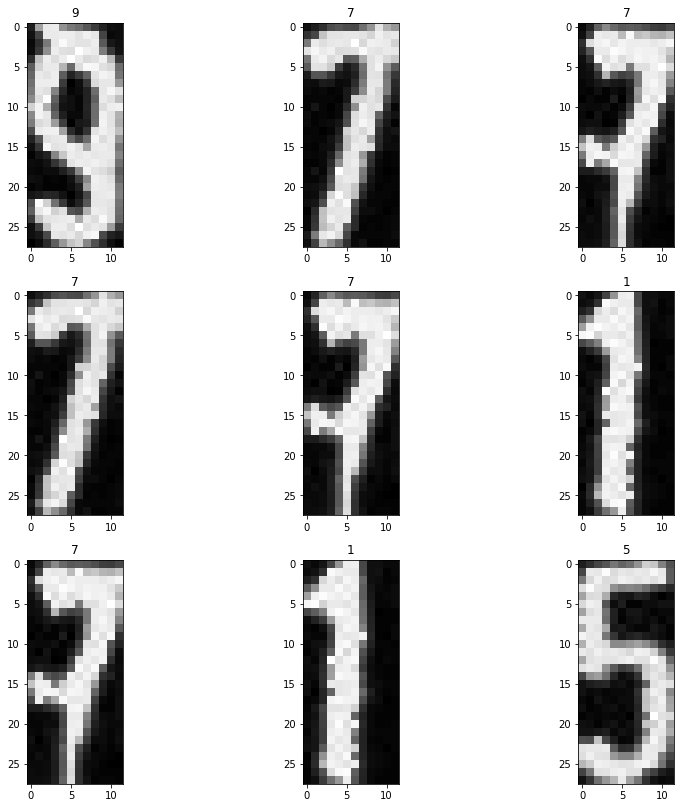

In [13]:
ds = ImageDataGenerator(
    rescale=1.0/255, 
    validation_split=0.2,
    fill_mode='constant',
    cval=0
)

train_ds = ds.flow_from_directory(
    "../numberLabel", 
    target_size=(28,12), 
    batch_size=128,
    subset='training',
    color_mode='grayscale',
    class_mode='sparse'
)

validation_ds = ds.flow_from_directory(
    "../numberLabel", 
    target_size=(28,12), 
    batch_size=128,
    subset='validation',
    color_mode='grayscale',
    class_mode='sparse'
)

input_shape = train_ds[0][0][0].shape

fig, axs = plt.subplots(3,3)
plt.rcParams["figure.figsize"] = (14,14)

for i in range(3):
    for j in range(3):
        axs[i, j].imshow(validation_ds[0][0][i + j], cmap='gray')
        axs[i, j].set_title(int(validation_ds[0][1][i + j]))

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(input_shape),
    tf.keras.layers.Conv2D(8, (3,3), activation='elu',
                           kernel_regularizer=tf.keras.regularizers.l2(1e-3), 
                           padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(16, (3,3), activation='elu',
                           kernel_regularizer=tf.keras.regularizers.l2(1e-3), 
                           padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='elu', 
                           kernel_regularizer=tf.keras.regularizers.l2(1e-3), 
                           padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 12, 8)         80        
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 12, 8)         32        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 6, 8)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 6, 16)         1168      
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 6, 16)         64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 3, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 3, 32)         

In [16]:
class stopCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}) :
        if (logs.get('val_accuracy') >= 0.999 and logs.get('accuracy') >= 0.999) :
            print('\nReached 99% accuracy so stopping training')
            self.model.stop_training = True

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='D:\\Code\\AI\\Model\\NumberRecognitionModel\\version9\\version9.hdf5',
                                                               monitor='val_loss',
                                                               mode='min',
                                                               save_best_only=True)

In [17]:
callback = stopCallback()

history = model.fit(train_ds, 
                    epochs=200, 
                    callbacks=[callback, model_checkpoint_callback], 
                    validation_data=validation_ds)

Epoch 1/200
256/256 [==============================] - 28s 110ms/step - loss: 0.2346 - accuracy: 0.9533 - val_loss: 0.7283 - val_accuracy: 0.9527
Epoch 2/200
256/256 [==============================] - 27s 107ms/step - loss: 0.0536 - accuracy: 0.9967 - val_loss: 0.0615 - val_accuracy: 0.9982
Epoch 3/200
256/256 [==============================] - 23s 91ms/step - loss: 0.0454 - accuracy: 0.9972 - val_loss: 0.0418 - val_accuracy: 0.9984
Epoch 4/200
153/256 [================>.............] - ETA: 9s - loss: 0.0407 - accuracy: 0.9980

KeyboardInterrupt: 

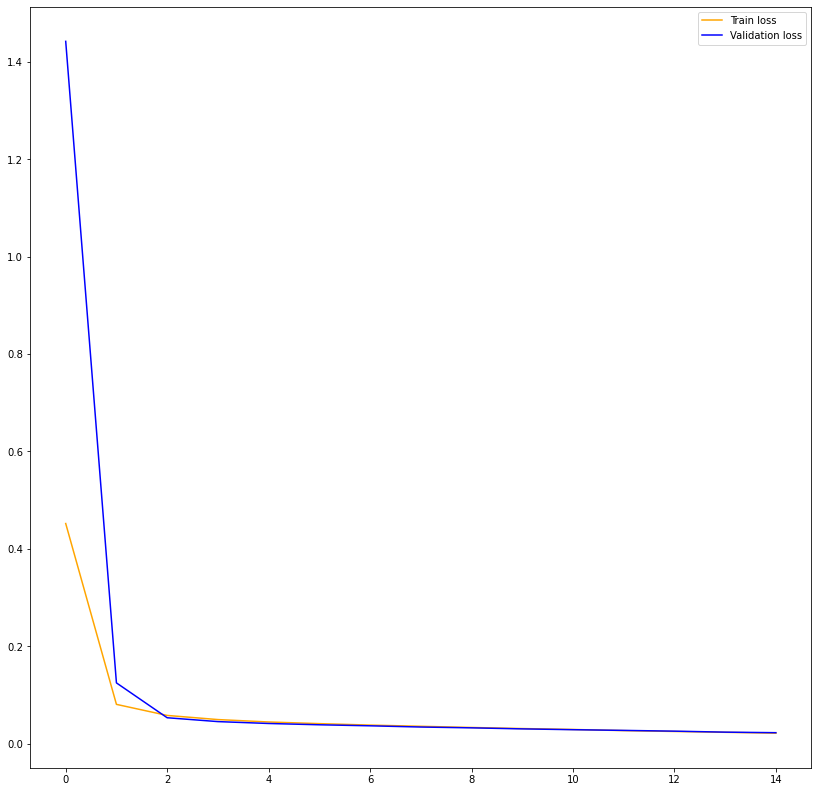

In [ ]:
plt.plot(history.history['loss'], color='orange', label='Train loss')
plt.plot(history.history['val_loss'], color='blue', label='Validation loss')
plt.legend()
plt.show()

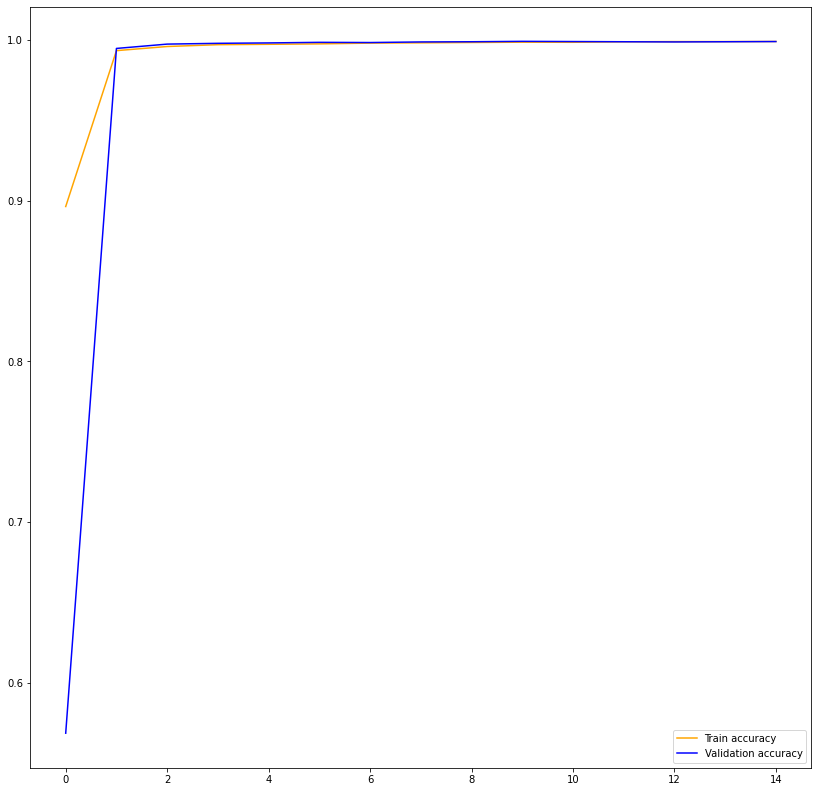

In [ ]:
plt.plot(history.history['accuracy'], color='orange', label='Train accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation accuracy')
plt.legend()
plt.show()